## Chessboard

This notebook studies knight distances on a chessboard, which is the minimum number of knights moves required to go from a point to another

We first start to create a chessboard object to compute the distance and trajectory on a (n*m) grid between two cells

The algorithm keeps track of the trajectory 

In [1]:
import pandas as pd
import numpy as np
from itertools import product
from functools import lru_cache
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class chessboard:
    def __init__(self, size=(8,8), add_pawn=False):
        self.size = size
        self.board = pd.DataFrame(
            index=range(size[0]),
            columns=range(size[1]),
            data=-1)
        self.deplacements = [
            (signe[0]*deplacement[0], signe[1]* deplacement[1])
            for signe in product([1,-1], [1,-1])
            for deplacement in [(1,2), (2,1)]
        ] 
        # to study how adding pawn movement change that
        if add_pawn:
            self.deplacements.extend([(1,0)])

    def coord_to_id(self, x, y):
        """
        attribute a unique id to each posiiton
        """
        return x + self.size[0]*y

    def id_to_coord(self, id):
        """
        retransform an id to a position
        """
        return (id%self.size[0], int(id//self.size[0]))

    @lru_cache(None)
    def find_all_nexts(self, start=(0,0)):
        """
        return neighbours af a given cell
        """
        possible_moves = filter(
            lambda pos: 
                (pos[0] >= 0) 
                & (pos[1] >= 0) 
                & (pos[0] < self.size[0]) 
                & (pos[1] < self.size[1]),
            map(
                lambda pos: (pos[0] + start[0], pos[1] + start[1]),
                self.deplacements
            )
        )
        return list(possible_moves)

    def plot_trajectory(self, trajectory):
        plt.figure(figsize=(self.size[0], self.size[1]))
        plt.axis('equal')
        plt.xlim(0, self.size[0])
        plt.ylim(0, self.size[1])
        plt.grid(True)

        for start, end in  zip(trajectory, trajectory[1:]):
            plt.arrow(start[0]+0.5, start[1]+0.5, end[0]-start[0], end[1]- start[1])

        plt.show()


    def find_shortest_path(self, start=(0,0), end=(1,1)):
        distance, predecesseur = self._find_shortest_path(start, end)
        trajectory = [end]
        for d in range(distance.loc[end[0], end[1]]):
            trajectory.append(
                self.id_to_coord(
                    predecesseur.loc[trajectory[-1][0], trajectory[-1][1]]
                )
            )
        return trajectory[::-1]

    def _find_shortest_path(self, start=(0,0), end=None):
        distance = self.board.copy()
        predecesseur = self.board.copy()
        current = [start]
        for i in range(100):
            tmp = []
            for point in current:
                voisins = [
                    v for v in self.find_all_nexts(point) 
                    if distance.loc[v[0], v[1]] < 0
                ]
                tmp.extend(voisins)
                for v in voisins:
                    distance.loc[v[0], v[1]] = i+1
                    predecesseur.loc[v[0], v[1]] = self.coord_to_id(*point)
                    if v == end:
                        # to break outer loop
                        tmp = []
                        break

            current = list(tmp)   
            if current == []:
                break

        return distance, predecesseur



In [27]:
a = chessboard((30,30))

In [29]:
traj = a.find_shortest_path((0,0), (29,29))

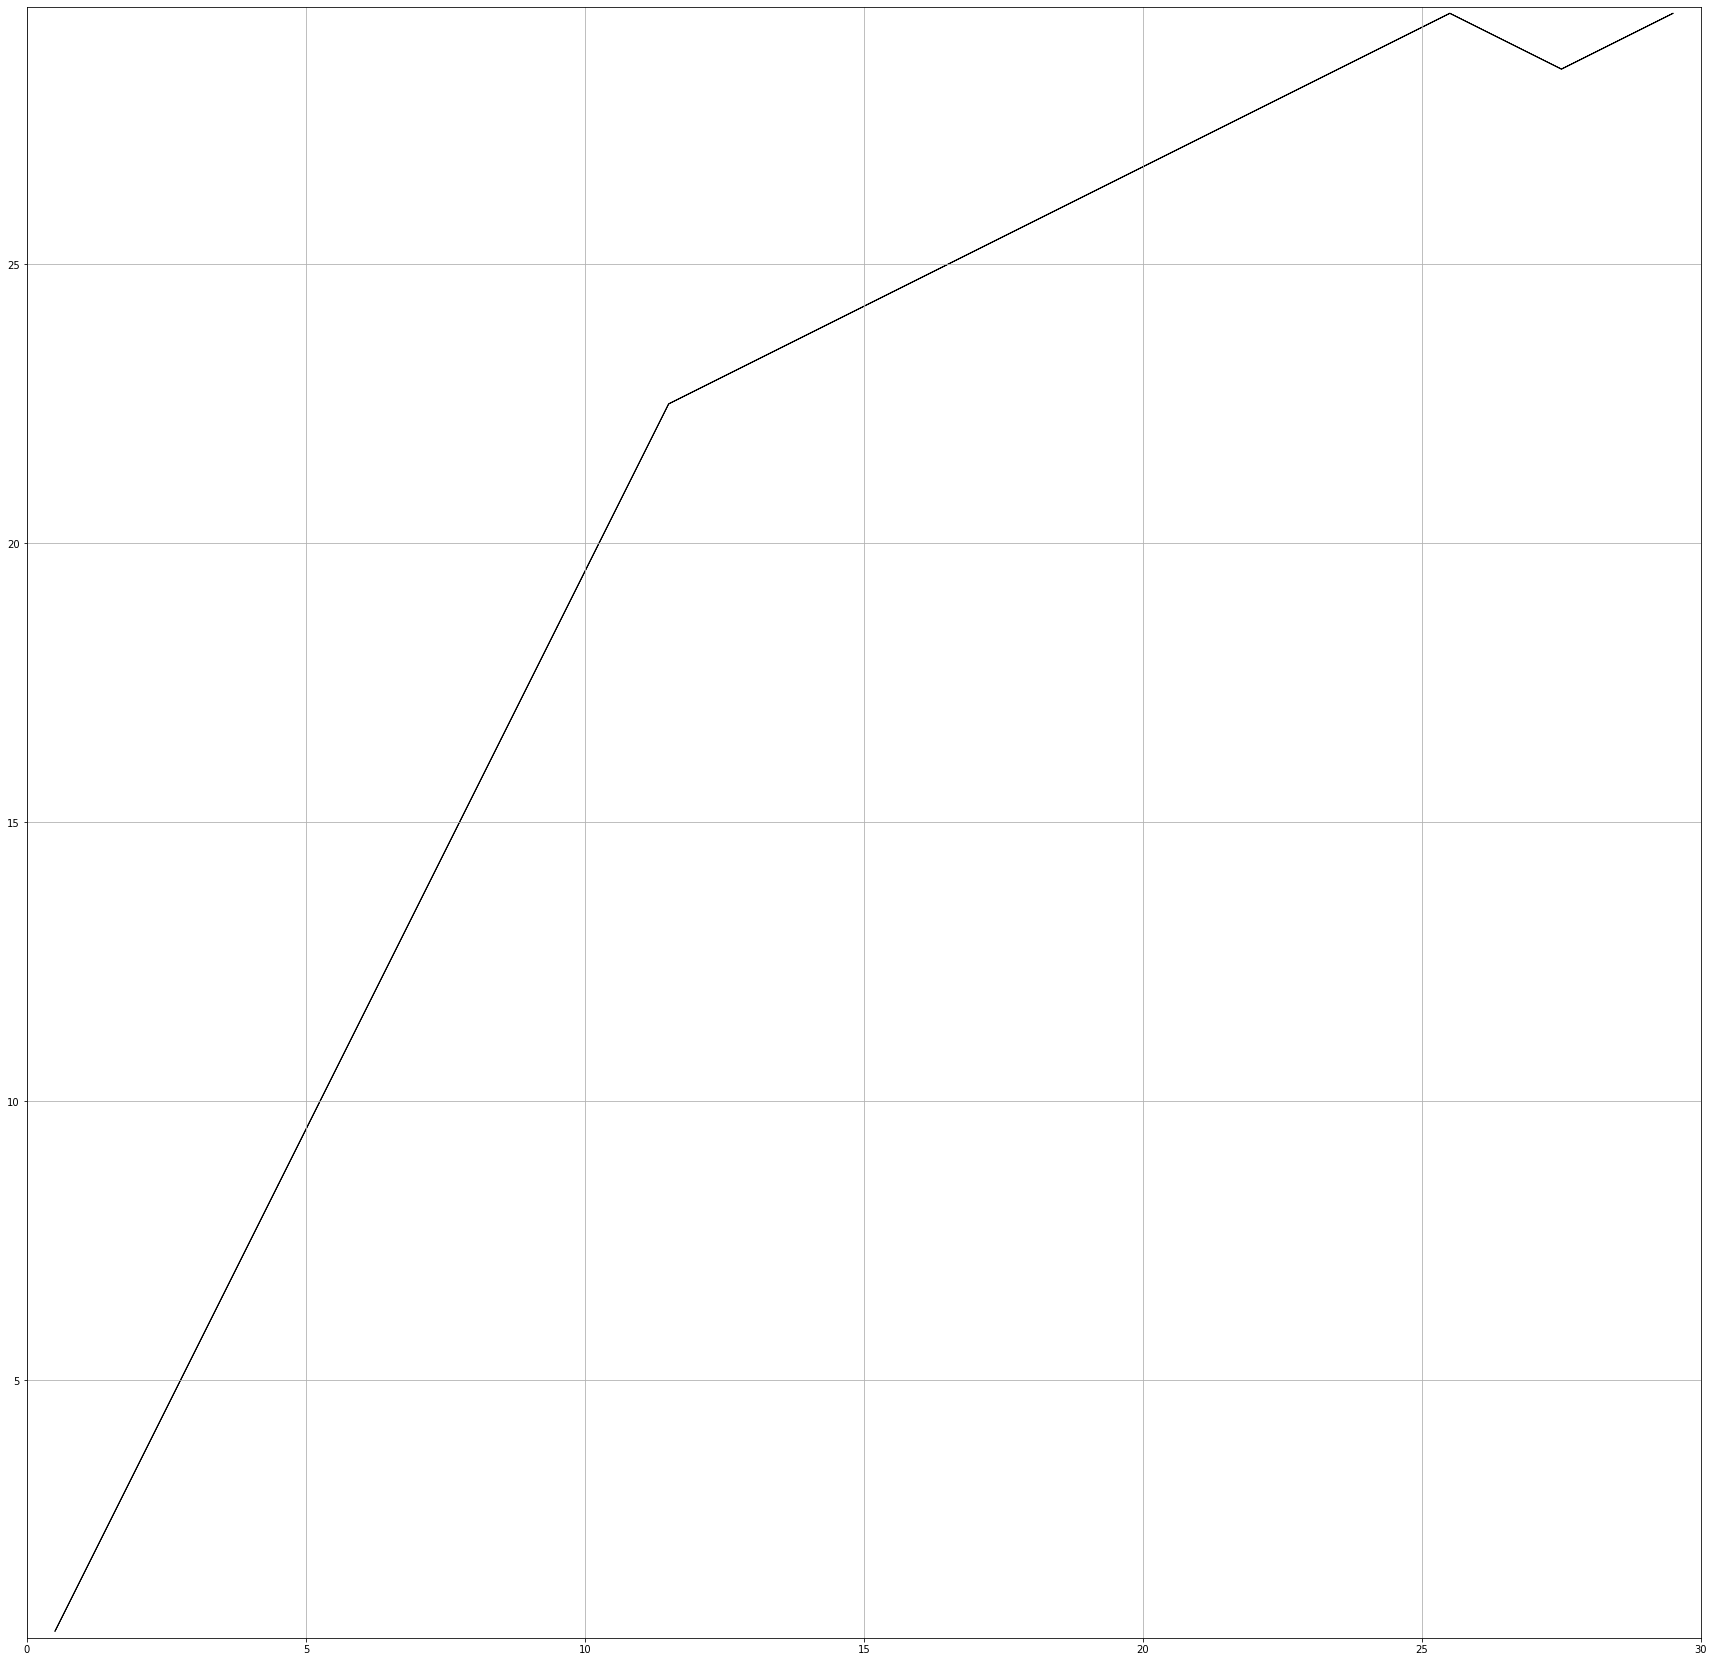

In [30]:
a.plot_trajectory(traj)

## longest path

what is the longest shortest path on a (n*n) chessboard ?

In [73]:
# we get rid of the class for simplicity sake 

deplacements = [
    (signe[0]*deplacement[0], signe[1]* deplacement[1])
    for signe in product([1,-1], [1,-1])
    for deplacement in [(1,2), (2,1)]
] 

@lru_cache(None)
def neighbours(start, n=8):
    possible_moves = filter(
        lambda pos: 
            (pos[0] >= 0) 
            & (pos[1] >= 0) 
            & (pos[0] < n) 
            & (pos[1] < n),
        map(
            lambda pos: (pos[0] + start[0], pos[1] + start[1]),
            deplacements
        )
    )
    return list(possible_moves)


@lru_cache(None)
def distance(a, b, n=8, depth=0):
    """
    assumes a knight can reach all cells
    """
    if depth > n:
        return None
    if a == b:
        return 0
    else:
        voisins = neighbours(a, n)
        dists = []
        for v in voisins:
            d = distance(v, b, n, depth=depth+1)
            if d is not None:
                dists.append(d)
        if len(dists) > 0:
            return 1 + min(dists)
        else:
            return None

In [74]:
n = 20

In [75]:
def compute_max_dist_table(n):
    """
    compute for each case of the board the max distance to another cell
    We dont assume the max distance is from a corner to its opposite in (x,y)
    """
    max_dist_table = pd.DataFrame(index=range(n), columns=range(n))
    for i in max_dist_table.index:
        for j in max_dist_table.columns:
            max_dist_table.loc[i, j] = max(
                [distance((i,j), (a,b), n=n) 
                    for a in max_dist_table.index
                        for b in max_dist_table.columns])
    return max_dist_table

In [76]:
# quite long ..
res = {}
for i in range(5, 20):
    res[i] = compute_max_dist_table(i).max().max()

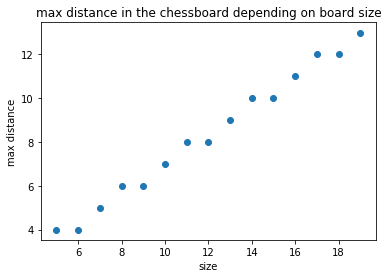

In [60]:
plt.scatter(res.keys(), res.values())
plt.xlabel('size')
plt.ylabel('max distance')
plt.title('max distance in the chessboard depending on board size')
plt.show()

Interesting. every third size increase the max distance doesnt increase 

## more efficient algorithm for longest path

our recursive algorithm is not efficient since the depth argument prevent from efficient caching

We can also exploit symmetries to divide by 4 the number of computation

can we find a more efficient algorithm

In [66]:
n = 32

In [67]:
def distance(a, n=8):
    level = {0: [a]}
    visited = set([a])
    for iteration in range(n):
        candidates = [neighbours(point, n) for point in level[iteration]]
        # flatten and remove diplicates
        candidates = set([p for liste in candidates for p in liste])
        # remove points already classified as closer
        candidates = candidates - visited
        if len(candidates) == 0:
            break
        level[iteration+1] = candidates
        visited = visited.union(candidates)
    return level

In [68]:
d = distance((n//2, n//2), n)

In [69]:
# settup the data in explitable format
reverted_d = dict([(v, key) for key, value in d.items() for v in value])
reverted_d = pd.DataFrame().from_dict(reverted_d, orient='index').reset_index()
reverted_d[['x', 'y']] = pd.DataFrame(reverted_d['index'].to_list())
reverted_d.drop('index', inplace=True, axis=1)
reverted_d.rename({0: 'distance'}, inplace=True, axis=1)
reverted_d = reverted_d.pivot_table(index='x', columns='y', values='distance')

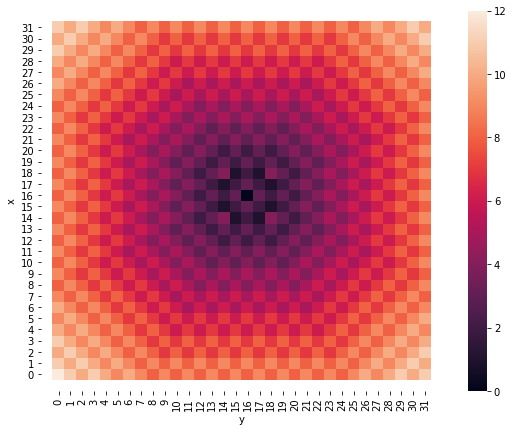

In [70]:
plt.figure(figsize=(9,7))
sns.heatmap(reverted_d)
plt.xlim(-1, n+1)
plt.ylim(-1, n+1)
plt.show()

TO BE CONTINUED